We will start by installing the previous version of Numpy to be able to run all the packages correctly. Please restart the runtime after this command.

In [1]:
!pip install numpy==1.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.8 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.


In [2]:
!pip install Cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Lab 7 - Social Media Processing

This notebook shows how to use HuggingFace's package to import and train regression models to assess humor rating in social media posts in English (SemEval2021: HaHackathon: Detecting and Rating Humor and Offense https://competitions.codalab.org/competitions/27446, **Task-1b**). 

Detection of humour, especially in social media posts, poses a linguistic challenge to NLP, due to the noise, figurative language, contextuality and subjectivity. You will hence try different methods to address those challenges such as preprocessing, data augmentation, ensembling and multi-task learning.

We will download and unzip the data from here: http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip. 


We recommend you to do this lab on a Colab TPU provided by Google.

In [ ]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip'

--2023-04-19 11:50:22--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip’

hahackathon_data.zi 100%[===================>] 558.21K  1.02MB/s    in 0.5s    

2023-04-19 11:50:23 (1.02 MB/s) - ‘hahackathon_data.zip’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
   creating: hahackathon data/
  inflating: hahackathon data/.DS_Store  
  inflating: __MACOSX/hahackathon data/._.DS_Store  
  inflating: hahackathon data/test.csv  
  inflating: __MACOSX/hahackathon data/._test.csv  
  inflating: hahackathon data/dev.csv  
  inflating: __MACOSX/hahackathon data/._dev.csv  
  inflating: hahackathon data/train.csv  
  inflating: __MACOSX/hahackathon data/._train.csv  


First, we need to install Hugging Face [transformers](https://huggingface.co/transformers/index.html) and [Sentence piece Tokenizers](https://github.com/google/sentencepiece), as well as some helper libraries, with the following commands.

In [3]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [4]:
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers.core import Dense
from keras.layers import Input, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

We define the fix seed method to be able to introduce variety into ensembling models.

In [8]:
def set_random_seed(seed=123):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed()

In [9]:


def plot_metrics(history, metrics=[]):
  for metric in metrics:
    plt.plot(range(1,len(history.history[metric])+1), history.history[metric], label=metric)
  plt.xlabel("Epochs")
  plt.legend()

## Regression with BERT

We will use the [DistilBert](https://arxiv.org/abs/1910.01108v4) model and its Tokeniser following the preprocessing code from Lab 6.

In [6]:
from transformers import DistilBertTokenizer
import tqdm

# we will pad to 128 subword tokens
PAD_LENGTH = 128
bert = 'distilbert-base-uncased'
BATCH_SIZE = 512
EPOCHS =10

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True, 
                                                max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,  
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
 
    return (np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32'))


Let's read the data using Pandas.

In [ ]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
test_df = test_df.dropna()

Let's check a couple of examples.

In [ ]:
train_df

,text,humor_rating,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,2.42,0.20
1,A man inserted an advertisement in the classif...,2.50,1.10
2,How many men does it take to open a can of bee...,1.95,2.40
3,Told my mom I hit 1200 Twitter followers. She ...,2.11,0.00
4,Roses are dead. Love is fake. Weddings are bas...,2.78,0.10
...,...,...,...
7991,"Sins are like viruses, it's better you keep th...",2.13,0.10
7993,My daughter wanted a Cinderella themed birthda...,3.70,0.00
7996,Why are aspirins white? Because they work sorry,1.33,3.85
7997,"Today, we Americans celebrate our independence...",2.55,0.00


In [ ]:
# Get the post text
train_examples_list = train_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [ ]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  targets = np.array(targets)

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


**Task 1: Build a neural bag of words model using DistilBERT embeddings and the sigmoid activation on the output layer for the regression task.**

Investigate its performance using the Mean Squared Error (MSE) metric. We will use this metric as the loss function as well. We will also use the Adam optimiser with `learning_rate=2e-5`. This code is already provided.

*Hint*: You can reuse the code from Lab 6 on Transfer Learning (Model 2).

In [10]:
from transformers import TFDistilBertModel, DistilBertConfig
import tensorflow as tf
 

class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)

def create_regression_BoW_bert():
  # Your code goes here
  BERT_layer = get_BERT_layer()

  input_ids = Input((128,), dtype="int32")
  input_masks_ids = Input((128,), dtype="int32")

  x2 = BERT_layer(input_ids, input_masks_ids)
  x3 = GlobalAveragePooling1DMasked()(x2[0])
  x4 = Dense(16, activation="relu")(x3)
  out_reg = Dense(1, activation="sigmoid")(x4)

  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])

def get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5):
  if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model on TPU:
    with strategy.scope():
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  elif use_gpu:
    device_name = tf.test.gpu_device_name()
    print(device_name)
    with tf.device('/device:GPU:0'):
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.losses.MeanSquaredError()])
  else:
    model = create_regression_BoW_bert()
    model.compile(optimizer='adam',
                loss='mse',
                metrics=[tf.keras.losses.MeanSquaredError()])
  return model

model = get_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 83s 3s/step - loss: 0.0139 - mean_squared_error: 0.0138
Epoch 2/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0120 - mean_squared_error: 0.0119
Epoch 3/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 4/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/10
10/10 [==============================] - 2s 179ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 7/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0097 - mean_squared_error: 0.0096
Epoch 8/10
10/10 [==============================] - 2s 179ms/step - loss: 0.0093 - mean_squared_error: 0.0094
Epoch 9/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0088 - mean_squared_error: 0.0089
Epoch 10/10


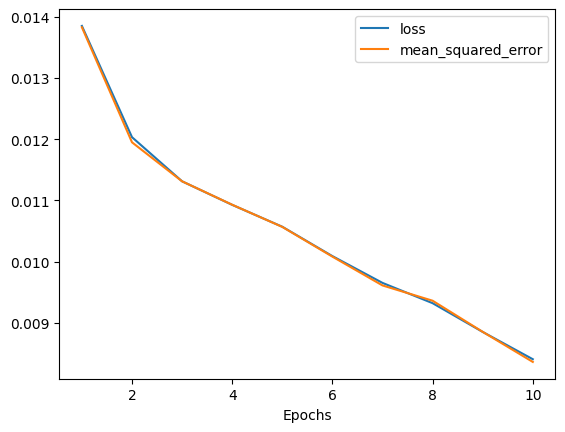

In [ ]:
plot_metrics(history, ["loss", "mean_squared_error"])

Create a dict to store the mse and loss on test for different models.

In [ ]:
test_performance = {}

We evaluate our model on the test set.

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w/o preprocessing"] = {"loss":results[0], "mse":results[1]}

20/20 [==============================] - 10s 131ms/step - loss: 0.0134 - mean_squared_error: 0.0129
Test loss: 0.013364320620894432
Test MSE: 0.012948649935424328


Get the array of predictions here so that you can plot the outputs later.

In [ ]:
preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)

preds = np.array(preds).flatten()

20/20 [==============================] - 9s 281ms/step


## Predictive Distribution

We compute min, max and mean for the golden and predicted humour ratings. 

In [ ]:
min(preds), max(preds), preds.mean()

(0.27087343, 0.57705045, 0.46906206)

In [ ]:
min(test_targets), max(test_targets), test_targets.mean()

(0.054000000000000006, 0.6839999999999999, 0.42383414634146344)

<Axes: >

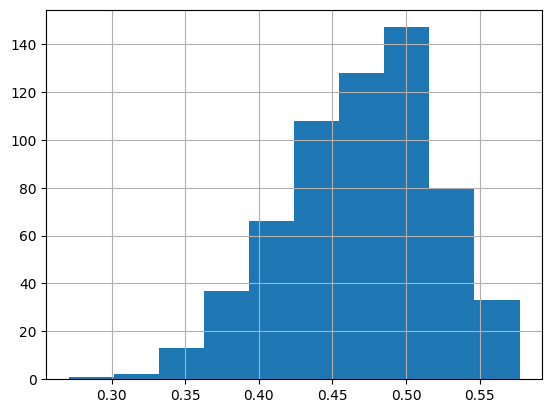

In [ ]:
pd.Series(preds).hist()

<Axes: >

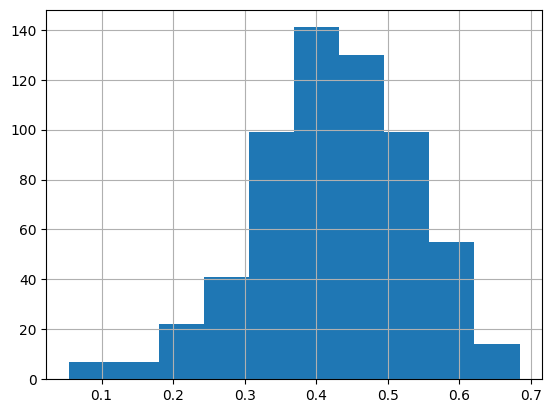

In [ ]:
pd.Series(test_targets).hist()

Next, we plot the true vs predicted humour grade for our model.

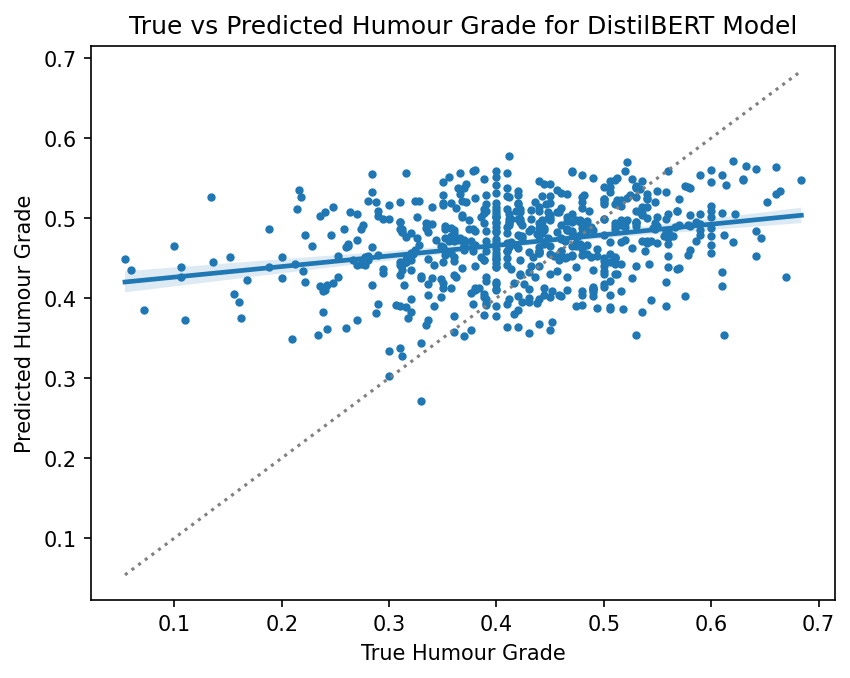

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, test_targets, 'True vs Predicted Humour Grade for DistilBERT Model')

Our regressor tends to smooth down the extreme rating values to make them closer to the mean.

# Feature Engineering & Data Augmentation

**Task 2: Preprocess the textual data with the Ekphrasis library following the standard pipeline https://github.com/cbaziotis/ekphrasis#text-pre-processing-pipeline. How does this affect the performance?**

*Hint*: You might not want to annotate terms in order to keep the same length of the input sentences (for this, do not use the parameter `annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'}`).

In [ ]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Your code goes here
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    normalize = ["url", "email", "percent", "money", "phone", "user",
                 "time", "url", "date", "number"],
    fix_html = True,
    unpack_hastag = True,
    unpack_contractions = True,
    spell_correction_elong = False,
    tokenizer = SocialTokenizer(lowercase=True).tokenize,
    dicts = [emoticons]
)


new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


/usr/local/lib/python3.9/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


/usr/local/lib/python3.9/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: tennessee : we are the best state . nobody even comes close . * elevennessee walks into the room * tennessee : oh shit . . .


In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)
 
model = get_model()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_3[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_4[0][0]']                
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 84s 3s/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 2/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 3/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 4/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 5/10
10/10 [==============================] - 2s 179ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 6/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 7/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 8/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 9/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 10/10


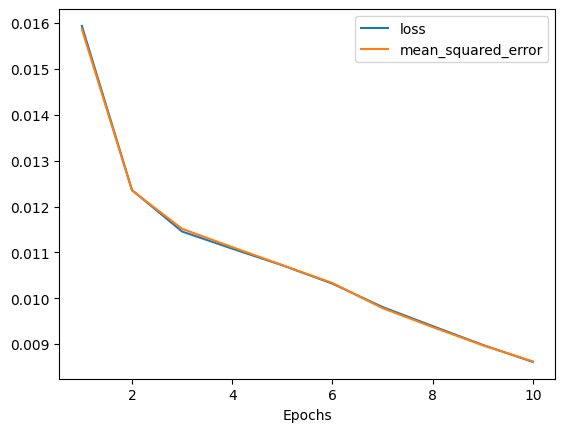

In [ ]:
plot_metrics(history, ["loss", "mean_squared_error"])

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w preprocessing"] = {"loss":results[0], "mse":results[1]}

20/20 [==============================] - 9s 131ms/step - loss: 0.0135 - mean_squared_error: 0.0131
Test loss: 0.013543364591896534
Test MSE: 0.01313617080450058


Your results may be different depending on the implementation but typically special preprocessing does not drastically change the performance for this task.

In [ ]:
pd.DataFrame(test_performance).T

,loss,mse
Regression w/o preprocessing,0.013364,0.012949
Regression w preprocessing,0.013543,0.013136


**Task 3: Augment the training data twice by changing the original data via two methods from the Nlpaug (https://github.com/makcedward/nlpaug) library: (a) synonym replacement from WordNet; (b) deletion of random words. Comment on which method gives the best performance.**

*Hint*: Use the Synonym Augmenter and Random Word Augmenter (Delete word randomly) classes as follows:
```
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)

aug = naw.RandomWordAug()
augmented_text = aug.augment(text)
```





For more examples check https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [ ]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.4 MB/s eta 0:00:00


Synonym Augmentation

In [ ]:
# Get the data again to apply augmentation
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

In [ ]:
import nlpaug.augmenter.word as naw

# Your code goes here
aug = naw.SynonymAug(aug_src='wordnet')
train_examples_list = aug.augment(train_examples_list)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


We have now augmented the original data twice:

In [ ]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
4932
Training examples after augmentation:
4932


In [ ]:
model = get_model()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_5[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_6[0][0]']                
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 86s 3s/step - loss: 0.0151 - mean_squared_error: 0.0149
Epoch 2/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 3/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 4/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 5/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 6/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0110 - mean_squared_error: 0.0111
Epoch 7/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0108 - mean_squared_error: 0.0107
Epoch 8/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 9/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 10/10


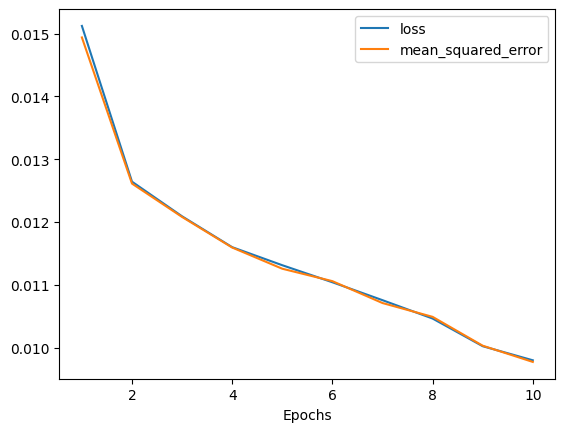

In [ ]:
plot_metrics(history, ["loss", "mean_squared_error"])

In [ ]:
results = model.evaluate([np.asarray(test_input_ids),np.asarray(test_attention_masks)], test_targets)
print("Synoynm Augmentation")
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w synonym aug"] = {"loss":results[0], "mse":results[1]}

20/20 [==============================] - 10s 131ms/step - loss: 0.0132 - mean_squared_error: 0.0129
Synoynm Augmentation
Test loss: 0.01321625430136919
Test MSE: 0.012879525311291218


Random Augmentation

In [ ]:
# Get the data again to apply augmentation
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()

In [ ]:
# Your code goes here
aug = naw.RandomWordAug()
train_examples_list = aug.augment(train_examples_list)

In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


We have now augmented the original data twice:

In [ ]:
print("Training examples before augmentation:")
print(len(train_df['text'].tolist()))
print("Training examples after augmentation:")
print(len(train_examples_list))

Training examples before augmentation:
4932
Training examples after augmentation:
4932


In [ ]:
model = get_model()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_7[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_8[0][0]']                
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 83s 3s/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 2/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 3/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0115 - mean_squared_error: 0.0116
Epoch 4/10
10/10 [==============================] - 2s 184ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 5/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0110 - mean_squared_error: 0.0109
Epoch 6/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 7/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 8/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 9/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 10/10


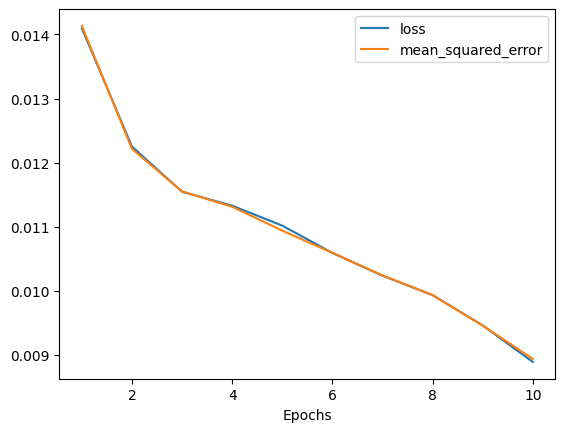

In [ ]:
plot_metrics(history, ["loss", "mean_squared_error"])

In [ ]:
results = model.evaluate([np.asarray(test_input_ids),np.asarray(test_attention_masks)], test_targets)
print("Random Augmentation")
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w random aug"] = {"loss":results[0], "mse":results[1]}

20/20 [==============================] - 9s 132ms/step - loss: 0.0118 - mean_squared_error: 0.0114
Random Augmentation
Test loss: 0.011831956915557384
Test MSE: 0.011428473517298698


Your results may be different depending on the implementation but typically there are no drastic differences between the augmentation setups.

Random augmentation performs better on the test set



In [ ]:
pd.DataFrame(test_performance).T

,loss,mse
Regression w/o preprocessing,0.013364,0.012949
Regression w preprocessing,0.013543,0.013136
Regression w synonym aug,0.013216,0.012880
Regression w random aug,0.011832,0.011428


# Ensembled BERT Model

In this section you will train and evaluate an **ensemble** of BERT models. 

We define the hyperparameters, including the number of models we want to ensemble (RERUNS=3, i.e., 3 models). 

**Task 4: Train three DistilBERT models, get their predictions on the test set, take the mean of those predictions and evaluate this ensembled prediction. Comment on the resulting performance.**

We create three models in a loop, set a new random seed before creating each of them (`set_random_seed(seed=random.randint(0, 500))`) and accumulate predictions per model in a list.

In [ ]:
# Get the train data again to avoid any confusion
train_examples_list = train_df['text'].tolist()
train_targets_list = (train_df['humor_rating']/5).tolist()
 
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)


In [ ]:
RERUNS = 3
# We save the predictions of each model to the list
all_model_preds = list()

####
hists = []
####

for i in range(RERUNS):

  set_random_seed(seed=random.randint(0, 500))

  # Your code goes here
  model = get_model()
  model.summary()
  history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)
  hists.append(history)
  results = model.predict([np.asarray(test_input_ids),np.asarray(test_attention_masks)])
  all_model_preds.append(results)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_7 (TFDist  TFBaseModelOutput(l  66362880   ['input_15[0][0]',               
 ilBertModel)                   ast_hidden_state=(N               'input_16[0][0]']               
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_8 (TFDist  TFBaseModelOutput(l  66362880   ['input_17[0][0]',               
 ilBertModel)                   ast_hidden_state=(N               'input_18[0][0]']               
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_9 (TFDist  TFBaseModelOutput(l  66362880   ['input_19[0][0]',               
 ilBertModel)                   ast_hidden_state=(N               'input_20[0][0]']               
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

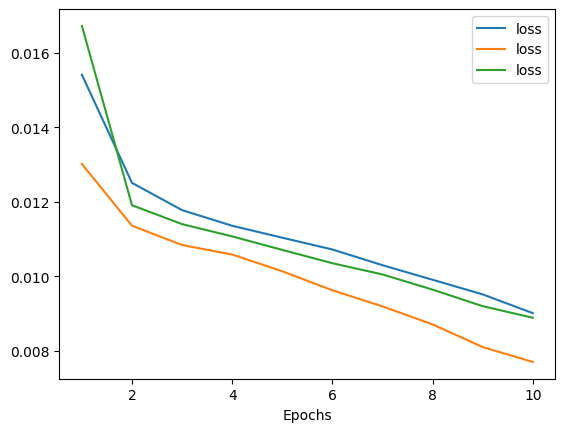

In [ ]:
plot_metrics(hists[0], ["loss"])
plot_metrics(hists[1], ["loss"])
plot_metrics(hists[2], ["loss"])

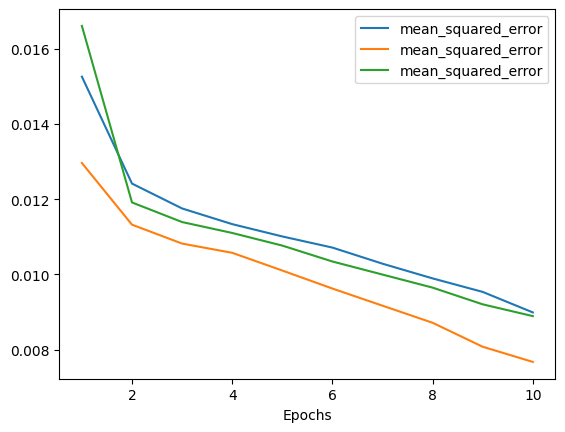

In [ ]:
plot_metrics(hists[0], ["mean_squared_error"])
plot_metrics(hists[1], ["mean_squared_error"])
plot_metrics(hists[2], ["mean_squared_error"])

In [ ]:
from sklearn.metrics import classification_report, mean_squared_error

mean_preds = np.mean(np.array(all_model_preds), axis=0)
ensemble_mse = mean_squared_error(test_targets, mean_preds)

print('Ensemble Test MSE : {:.4f}'.format(ensemble_mse))

Ensemble Test MSE : 0.0132


In [ ]:
for i in range(RERUNS):
  single_mse = mean_squared_error(test_targets, all_model_preds[i])
  print(f"Model {i}, MSE:", single_mse)

Model 0, MSE: 0.013639373353434089
Model 1, MSE: 0.013880603922923162
Model 2, MSE: 0.013297223413024833


In [ ]:
test_performance["Regression w 3 ensembles"] = {"mse":ensemble_mse}

Your results may be different depending on the implementation but typically ensembling slightly improves the performance for this task.

In [ ]:
pd.DataFrame(test_performance).T

,loss,mse
Regression w/o preprocessing,0.013364,0.012949
Regression w preprocessing,0.013543,0.013136
Regression w synonym aug,0.013216,0.012880
Regression w random aug,0.011832,0.011428
Regression w 3 ensembles,NaN,0.013242


# Multi-task Learning with BERT

**Task 6: Train a multi-task (MTL) model with the additional regression task of predicting the offense rating. Re-train the single-task model from Task 1 with half of the initial training data. The code to fetch these data is provided below. Comment on the resulting performance for the regresion task in the data sparsity conditions for the two models (single-task and MTL).** 

*Hint*: The MTL model will have two identical output layers (one for predicting humour rating, the other to predict offense rating).

We specify two losses and two metrics to compile the model `loss={'out_reg1': 'mse', 'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 'out_reg2': 'mse'}`. We increase the epoch count to 25 due to the reduced training data.

In [ ]:
def create_regression_BoW_bert():
  # Your code goes here
  BERT_layer = get_BERT_layer()

  input_ids = Input((128,), dtype="int32")
  input_masks_ids = Input((128,), dtype="int32")

  x2 = BERT_layer(input_ids, input_masks_ids)
  x3 = GlobalAveragePooling1DMasked()(x2[0])
  x4 = Dense(16, activation="relu")(x3)
  out_reg = Dense(1, activation="sigmoid")(x4)

  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])



In [ ]:
set_random_seed()

from transformers import TFDistilBertModel, DistilBertConfig

def create_TFBertMultitask():

  # Your code goes here
  BERT_layer = get_BERT_layer()

  input_ids = Input((128,), dtype="int32", name="input_token")
  input_masks_ids = Input((128,), dtype="int32", name="masked_token")
  x2 = BERT_layer(input_ids, input_masks_ids)
  x3 = GlobalAveragePooling1DMasked()(x2[0])
  x4 = Dense(16, activation="relu")(x3)
  out_reg1 = Dense(1, activation="sigmoid", name="out_reg1")(x4)
  out_reg2 = Dense(1, activation="sigmoid", name="out_reg2")(x4)

  # comment to run a single-task model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1, out_reg2])
  # uncomment to run a single-task model
  # return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1])

use_tpu = True
use_gpu = False
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # comment to run a single-task model
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})
    # uncomment to run a single-task model
    # model.compile(optimizer=optimizer, loss={'out_reg1': 'mse'}, metrics={'out_reg1': 'mse'})
  
elif use_gpu:
  device_name = tf.test.gpu_device_name()
  print(device_name)
  with tf.device('/device:GPU:0'):
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})
else:
  model = create_TFBertMultitask()
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_10 (TFDis  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 tilBertModel)                  ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                        

Multiple

In [ ]:
# Get half of the training data
train_examples_list = train_df['text'].tolist()[2500:]
train_targets_list = (train_df['humor_rating']/5).tolist()[2500:]

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

# Get the offense ratings for the second regression task (we normalise them as well)
train_targets2_list = (train_df['offense_rating']/5).tolist()[2500:]
test_targets2_list = (test_df['offense_rating']/5).tolist()
 
train_targets2 = np.array(train_targets2_list)
test_targets2 = np.array(test_targets2_list)

In [ ]:
# comment to run a single-task model

history = model.fit([train_input_ids, train_attention_masks],
                    [train_targets, train_targets2],
                    epochs=25,
                    batch_size=BATCH_SIZE,
                    verbose=1)

# uncomment to run a single-task model
# history = model.fit([train_input_ids, train_attention_masks],
#                    [train_targets],
#                    epochs=25,
#                    batch_size=BATCH_SIZE,
#                    verbose=1)

Epoch 1/25
5/5 [==============================] - 95s 8s/step - loss: 0.1089 - out_reg1_loss: 0.0152 - out_reg2_loss: 0.0937 - out_reg1_mse: 0.0152 - out_reg2_mse: 0.0937
Epoch 2/25
5/5 [==============================] - 1s 193ms/step - loss: 0.0665 - out_reg1_loss: 0.0135 - out_reg2_loss: 0.0530 - out_reg1_mse: 0.0135 - out_reg2_mse: 0.0530
Epoch 3/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0689 - out_reg1_loss: 0.0130 - out_reg2_loss: 0.0559 - out_reg1_mse: 0.0130 - out_reg2_mse: 0.0559
Epoch 4/25
5/5 [==============================] - 1s 194ms/step - loss: 0.0657 - out_reg1_loss: 0.0123 - out_reg2_loss: 0.0534 - out_reg1_mse: 0.0123 - out_reg2_mse: 0.0534
Epoch 5/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0613 - out_reg1_loss: 0.0119 - out_reg2_loss: 0.0494 - out_reg1_mse: 0.0119 - out_reg2_mse: 0.0494
Epoch 6/25
5/5 [==============================] - 1s 194ms/step - loss: 0.0597 - out_reg1_loss: 0.0117 - out_reg2_loss: 0.0480 - out_reg1

In [ ]:
history.history.keys()

dict_keys(['loss', 'out_reg1_loss', 'out_reg2_loss', 'out_reg1_mse', 'out_reg2_mse'])

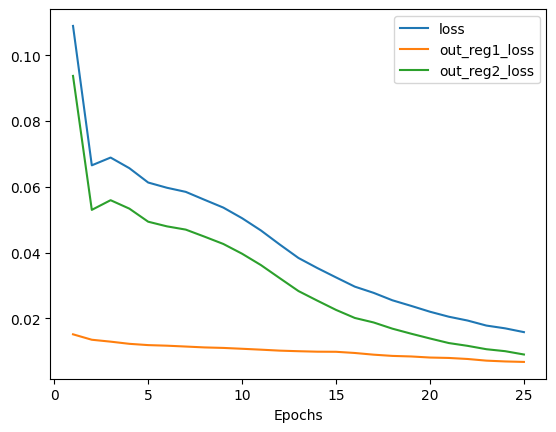

In [ ]:
plot_metrics(history, ["loss", "out_reg1_loss", "out_reg2_loss"])

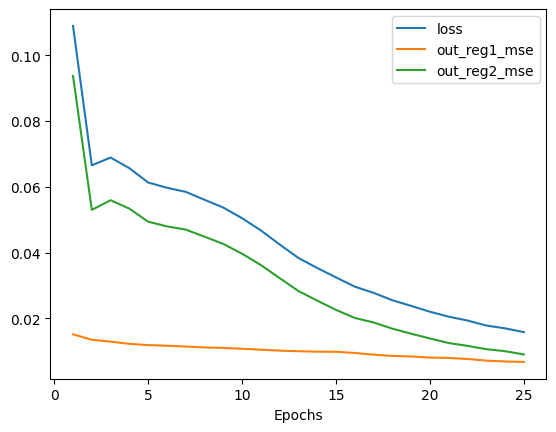

In [ ]:
plot_metrics(history, ["loss", "out_reg1_mse", "out_reg2_mse"])

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], [test_targets, test_targets2])
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w multitask"] = {"loss": results[0], "mse":results[1]}

20/20 [==============================] - 2s 46ms/step - loss: 0.0321 - out_reg1_loss: 0.0137 - out_reg2_loss: 0.0184 - out_reg1_mse: 0.0137 - out_reg2_mse: 0.0184
Test loss: 0.03209678456187248
Test MSE: 0.013659887947142124


Single

In [11]:
set_random_seed()

from transformers import TFDistilBertModel, DistilBertConfig

def create_TFBertMultitask():

  # Your code goes here
  BERT_layer = get_BERT_layer()

  input_ids = Input((128,), dtype="int32", name="input_token")
  input_masks_ids = Input((128,), dtype="int32", name="masked_token")
  x2 = BERT_layer(input_ids, input_masks_ids)
  x3 = GlobalAveragePooling1DMasked()(x2[0])
  x4 = Dense(16, activation="relu")(x3)
  out_reg1 = Dense(1, activation="sigmoid", name="out_reg1")(x4)
  out_reg2 = Dense(1, activation="sigmoid", name="out_reg2")(x4)

  # comment to run a single-task model
  # return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1, out_reg2])
  # uncomment to run a single-task model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = [out_reg1])

use_tpu = True
use_gpu = False
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # comment to run a single-task model
    # model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
    #                      'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
    #                       'out_reg2': 'mse'})
    # uncomment to run a single-task model
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse'}, metrics={'out_reg1': 'mse'})
  
elif use_gpu:
  device_name = tf.test.gpu_device_name()
  print(device_name)
  with tf.device('/device:GPU:0'):
    model = create_TFBertMultitask()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})
else:
  model = create_TFBertMultitask()
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  model.compile(optimizer=optimizer, loss={'out_reg1': 'mse', 
                         'out_reg2': 'mse'}, metrics={'out_reg1': 'mse', 
                          'out_reg2': 'mse'})


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
# Get half of the training data
train_examples_list = train_df['text'].tolist()[2500:]
train_targets_list = (train_df['humor_rating']/5).tolist()[2500:]

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)

 
train_targets = np.array(train_targets_list)
test_targets = np.array(test_targets_list)

In [ ]:
# comment to run a single-task model

# history = model.fit([train_input_ids, train_attention_masks],
#                     [train_targets, train_targets2],
#                     epochs=25,
#                     batch_size=BATCH_SIZE,
#                     verbose=1)

# uncomment to run a single-task model
history = model.fit([train_input_ids, train_attention_masks],
                   [train_targets],
                   epochs=25,
                   batch_size=BATCH_SIZE,
                   verbose=1)

Epoch 1/25
5/5 [==============================] - 91s 8s/step - loss: 0.0145 - mse: 0.0145
Epoch 2/25
5/5 [==============================] - 1s 183ms/step - loss: 0.0126 - mse: 0.0126
Epoch 3/25
5/5 [==============================] - 1s 180ms/step - loss: 0.0118 - mse: 0.0118
Epoch 4/25
5/5 [==============================] - 1s 183ms/step - loss: 0.0114 - mse: 0.0114
Epoch 5/25
5/5 [==============================] - 1s 186ms/step - loss: 0.0109 - mse: 0.0109
Epoch 6/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0104 - mse: 0.0104
Epoch 7/25
5/5 [==============================] - 1s 184ms/step - loss: 0.0102 - mse: 0.0102
Epoch 8/25
5/5 [==============================] - 1s 186ms/step - loss: 0.0097 - mse: 0.0097
Epoch 9/25
5/5 [==============================] - 1s 181ms/step - loss: 0.0094 - mse: 0.0094
Epoch 10/25
5/5 [==============================] - 1s 180ms/step - loss: 0.0089 - mse: 0.0089
Epoch 11/25
5/5 [==============================] - 1s 185ms/step - loss

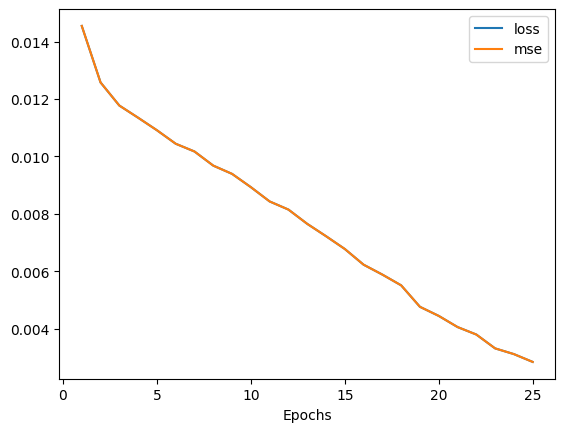

In [ ]:
plot_metrics(history, ["loss", "mse"])

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test MSE:', results[1])

test_performance["Regression w singletask"] = {"loss":results[0], "mse":results[1]}

20/20 [==============================] - 13s 148ms/step - loss: 0.0160 - mse: 0.0160
Test loss: 0.01604236476123333
Test MSE: 0.01604236476123333


Your results may be different depending on the implementation but typically MTL slightly improves the performance over the single-task model trained in similar conditions.

In [ ]:
pd.DataFrame(test_performance).T

,loss,mse
Regression w/o preprocessing,0.013364,0.012949
Regression w preprocessing,0.013543,0.013136
Regression w synonym aug,0.013216,0.012880
Regression w random aug,0.011832,0.011428
Regression w 3 ensembles,NaN,0.013242
Regression w multitask,0.032097,0.013660
Regression w singletask,0.016042,0.016042
